In [1]:
using DataFrames
using Chemfiles
using MIToS.PDB
using Gadfly
using Cairo
using Compose
set_default_plot_size(40cm, 14cm)

home = "/home/german/labo/18/egfr/cavidad"
home_rtdos = "/home/german/labo/18/egfr/rtdos_log"
aa = 277

INFO: Precompiling module Gadfly.


277

In [2]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [3]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        if i == 1
            # Include those that fall before the beggining of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
            out_counts[i] = sum(in_weight[temp_bool])
        elseif i == length(in_bins)-1
            # Include those that fall after the end of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
            out_counts[i] = sum(in_weight[temp_bool])
        else
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

In [23]:
function displaceAA(mod_pdb, in_vector, multiplier)
    # Preparo variables
    pdb = copy(mod_pdb)
    struct_xyz = coordinatesmatrix(pdb)
    new_struct_xyz = copy(struct_xyz)
        aa = length(pdb)
        # Determino el nro de atomos de c/ aminoácido
        natom = Array{Int64}(aa)
        [ natom[i] = length(pdb[i]) for i = 1:aa ]
        # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
        vector = Array{Float64}
        const tmp_size = size(in_vector)
        const natoms = sum(natom)

        if tmp_size == (aa*3, )
                vector = transpose(reshape(in_vector, 3, aa))
        elseif tmp_size == (aa, 3)
                vector = in_vector
        else
                error("Input vector with wrong dimensions: ", tmp_size, "  ", (aa*3, 1))
        end
        sum_mat = Array{Float64}(sum(natom),3)
        cursor = 0
        for i = 1:aa
                rango = Array{Int64}(natom[i])
        if i == 1
                        sum_mat[1:natom[i], :] = repmat(transpose(vector[i, :]),
                                natom[i], 1)
                        cursor = natom[i]
                        continue
                end
                rango = collect(cursor+1:cursor + natom[i])
                sum_mat[rango, :] = repmat(transpose(vector[i, :]), natom[i], 1)
                cursor += natom[i]
        end

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

# Cavidad

In [38]:
# Leo nombres de structuras
tmp = readdlm(joinpath(home, "pdbs.list"))
pdbs_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));
aa = 277
aa_3 = aa * 3
aa_36 = aa_3 - 6
structs = length(pdbs_list)

# Leo activas e inactivas
tmp = readdlm(joinpath(home, "am.list"))
am_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

tmp = readdlm(joinpath(home, "im.list"))
im_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

cfg_filename = joinpath(home, "egfr.cfg")

"/home/german/labo/18/egfr/cavidad/egfr.cfg"

In [110]:
# Read PDB
for each in pdbs_list
    # Leo pdb
    in_pdb_filename = string(each, ".pdb")
    in_pdb = read(joinpath(home, each, in_pdb_filename), PDBFile, group="ATOM");

    # Leo modo 1
    in_vec1_filename = string("1modo_", each)
    tmp = readdlm(joinpath(home, each, in_vec1_filename))
    modo_1 = reshape(tmp, length(tmp))

    # Desplazo
    out_pdb_1_neg = displaceAA(in_pdb, modo_1, -5.0)
    out_pdb_1_pos = displaceAA(in_pdb, modo_1, 5.0)

    # Guardo la struct modificada
    out_filename_1_neg = string("_5_modo1_", each, ".pdb")
    write(joinpath(home, each, out_filename_1_neg), out_pdb_1_neg, PDBFile)
    out_filename_1_pos = string("5_modo1_", each, ".pdb")
    write(joinpath(home, each, out_filename_1_pos), out_pdb_1_pos, PDBFile)


    # Leo modo 2 y desplazo
    in_vec2_filename = string("2modo_", each)
    tmp = readdlm(joinpath(home, each, in_vec2_filename))
    modo_2 = reshape(tmp, length(tmp));

    # Desplazo
    out_pdb_2_neg = displaceAA(in_pdb, modo_2, -5.0)
    out_pdb_2_pos = displaceAA(in_pdb, modo_2, 5.0)

    # Guardo las struct modificadas
    out_filename_2_neg = string("_5_modo2_", each, ".pdb")
    write(joinpath(home, each, out_filename_2_neg), out_pdb_2_neg, PDBFile)
    out_filename_2_pos = string("5_modo2_", each, ".pdb")
    write(joinpath(home, each, out_filename_2_pos), out_pdb_2_pos, PDBFile)
end

In [116]:
# IM
der_im_1 = Array{Float64}(length(im_list))
der_im_2 = Array{Float64}(length(im_list))
for i = 1:length(im_list)
    each = pdbs_list[i]
    in_pdb_filename_1_neg = joinpath(home, each, string("_5_modo1_", each, ".pdb"))
    in_pdb_filename_1_pos = joinpath(home, each, string("5_modo1_", each, ".pdb"))
    in_pdb_filename_2_neg = joinpath(home, each, string("_5_modo2_", each, ".pdb"))
    in_pdb_filename_2_pos = joinpath(home, each, string("5_modo2_", each, ".pdb"))

    out_filename_1_neg = joinpath(home, each, string("vol_1_5"))
    out_filename_1_pos = joinpath(home, each, string("vol_1__5"))
    out_filename_2_neg = joinpath(home, each, string("vol_2_5"))
    out_filename_2_pos = joinpath(home, each, string("vol_2__5"))

    run(pipeline(`ANA $in_pdb_filename_1_neg -c $cfg_filename`, stdout = out_filename_1_neg))
    run(pipeline(`ANA $in_pdb_filename_1_pos -c $cfg_filename`, stdout = out_filename_1_pos))
    run(pipeline(`ANA $in_pdb_filename_2_neg -c $cfg_filename`, stdout = out_filename_2_neg))
    run(pipeline(`ANA $in_pdb_filename_2_pos -c $cfg_filename`, stdout = out_filename_2_pos))

    vol_1__5 = readdlm(out_filename_1_neg)[end]
    vol_1_5 = readdlm(out_filename_1_pos)[end]
    vol_2__5 = readdlm(out_filename_2_neg)[end]
    vol_2_5 = readdlm(out_filename_2_pos)[end]

    der_im_1[i] = vol_1_5 - vol_1__5
    der_im_2[i] = vol_2_5 - vol_2__5    
end


# AM
der_am_1 = Array{Float64}(length(am_list))
der_am_2 = Array{Float64}(length(am_list))
for i = 1:length(am_list)
    each = pdbs_list[i]
    in_pdb_filename_1_neg = joinpath(home, each, string("_5_modo1_", each, ".pdb"))
    in_pdb_filename_1_pos = joinpath(home, each, string("5_modo1_", each, ".pdb"))
    in_pdb_filename_2_neg = joinpath(home, each, string("_5_modo2_", each, ".pdb"))
    in_pdb_filename_2_pos = joinpath(home, each, string("5_modo2_", each, ".pdb"))

    out_filename_1_neg = joinpath(home, each, string("vol_1_5"))
    out_filename_1_pos = joinpath(home, each, string("vol_1__5"))
    out_filename_2_neg = joinpath(home, each, string("vol_2_5"))
    out_filename_2_pos = joinpath(home, each, string("vol_2__5"))

    run(pipeline(`ANA $in_pdb_filename_1_neg -c $cfg_filename`, stdout = out_filename_1_neg))
    run(pipeline(`ANA $in_pdb_filename_1_pos -c $cfg_filename`, stdout = out_filename_1_pos))
    run(pipeline(`ANA $in_pdb_filename_2_neg -c $cfg_filename`, stdout = out_filename_2_neg))
    run(pipeline(`ANA $in_pdb_filename_2_pos -c $cfg_filename`, stdout = out_filename_2_pos))

    vol_1__5 = readdlm(out_filename_1_neg)[end]
    vol_1_5 = readdlm(out_filename_1_pos)[end]
    vol_2__5 = readdlm(out_filename_2_neg)[end]
    vol_2_5 = readdlm(out_filename_2_pos)[end]

    der_am_1[i] = vol_1_5 - vol_1__5
    der_am_2[i] = vol_2_5 - vol_2__5    
end

In [117]:
der_im_1 = abs.(der_im_1)
der_im_2 = abs.(der_im_2)
der_am_1 = abs.(der_am_1)
der_am_2 = abs.(der_am_2);

## Grafico

In [121]:
# Vec 1
hbins = collect(minimum(der_im_1):10.0:maximum(der_am_1))
hweights_im = repeat([1.0], inner = [length(der_im_1)])
hweights_am = repeat([1.0], inner = [length(der_am_1)])

counts_im, bins = WeightedHist(der_im_1, hbins, hweights_im, true)
counts_am, bins = WeightedHist(der_am_1, hbins, hweights_am, true)


df_hist_der_vec1 = DataFrame(Probability = [counts_am ; counts_im],
    ΔVol = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]));

# Vec 2
hbins = collect(minimum(der_im_2):10.:maximum(der_am_2))
hweights_im = repeat([1.0], inner = [length(der_im_2)])
hweights_am = repeat([1.0], inner = [length(der_am_2)])

counts_im, bins = WeightedHist(der_im_1, hbins, hweights_im, true)
counts_am, bins = WeightedHist(der_am_1, hbins, hweights_am, true)


df_hist_der_vec2 = DataFrame(Probability = [counts_am ; counts_im],
    ΔVol = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]));

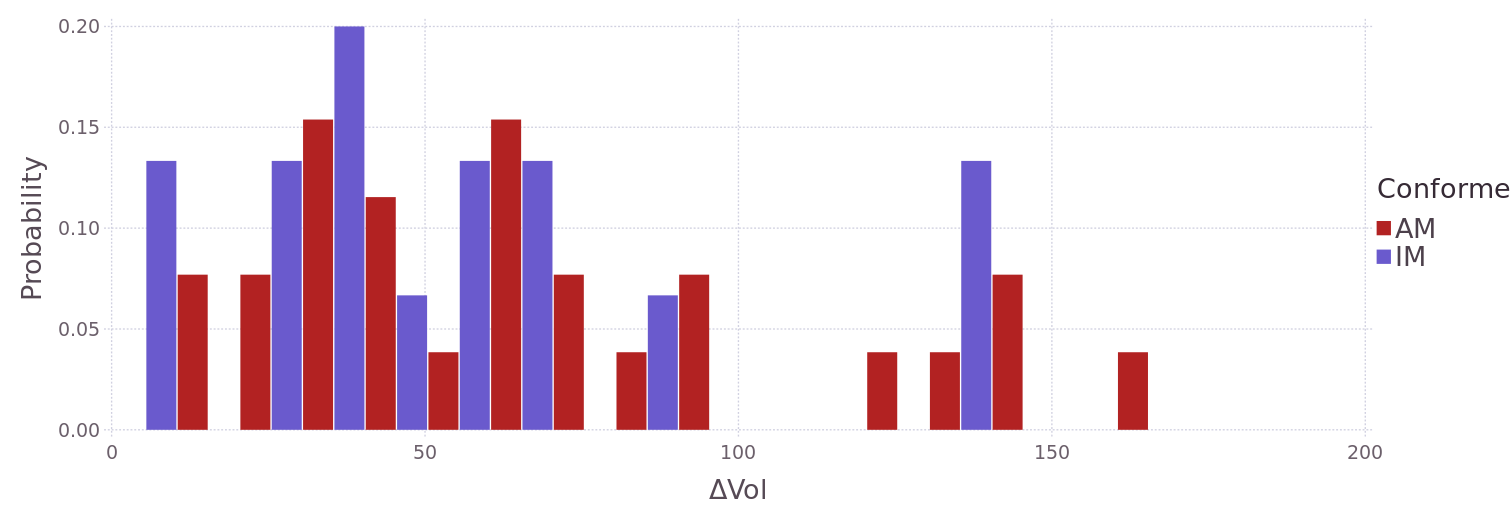

In [122]:
pdf_hist_der_vec1 = plot(df_hist_der_vec1, x="ΔVol", y="Probability", color = "Conformer", 
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    #Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    #Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("Firebrick","SlateBlue"),


    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

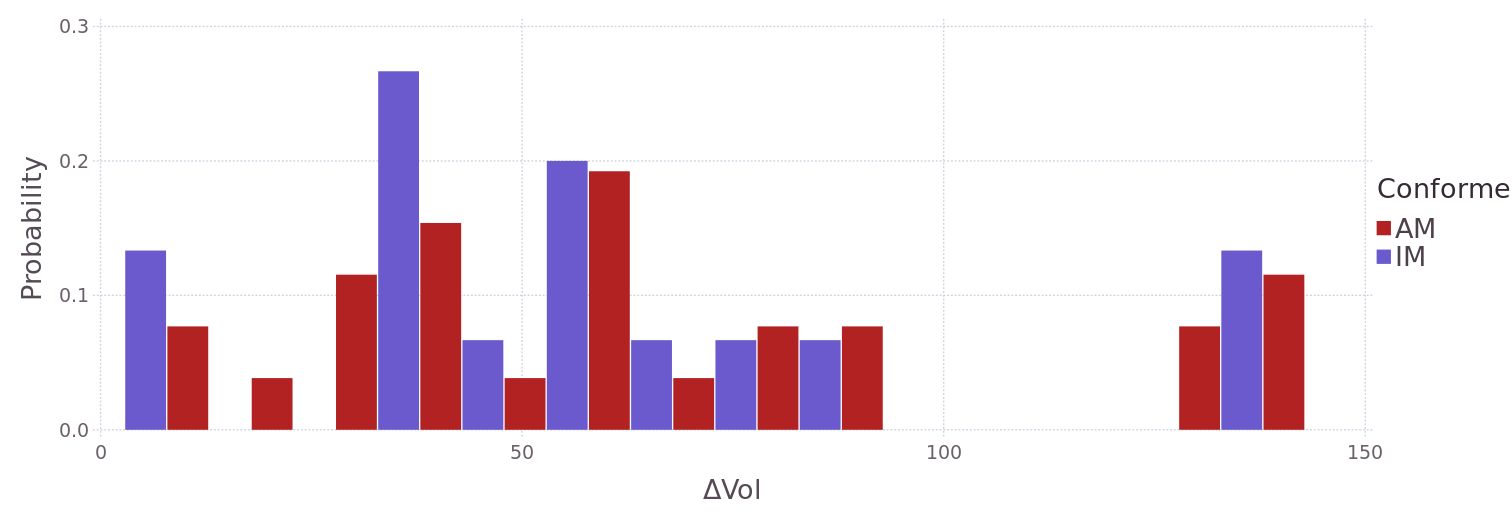

In [123]:
pdf_hist_der_vec2 = plot(df_hist_der_vec2, x="ΔVol", y="Probability", color = "Conformer", 
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    #Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    #Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("Firebrick","SlateBlue"),


    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

## Guardo resultados

In [ ]:
writedlm(string(home_rtdos, "rg_im_vec1"), der_im_vec1)
writedlm(string(home_rtdos, "rg_im_vec2"), der_im_vec2)

writedlm(string(home_rtdos, "rg_am_vec1"), der_am_vec1)
writedlm(string(home_rtdos, "rg_am_vec2"), der_am_vec2)